In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl
import random

# OBTENDO DADOS

In [58]:
df = pd.read_csv('DataBase.csv')
print('size:', len(df))
df.head()

size: 274


,time,input,output
0,0.00,135,3.69
1,0.00,135,3.67
2,0.01,135,3.69
3,0.01,135,3.69
4,0.01,135,3.67


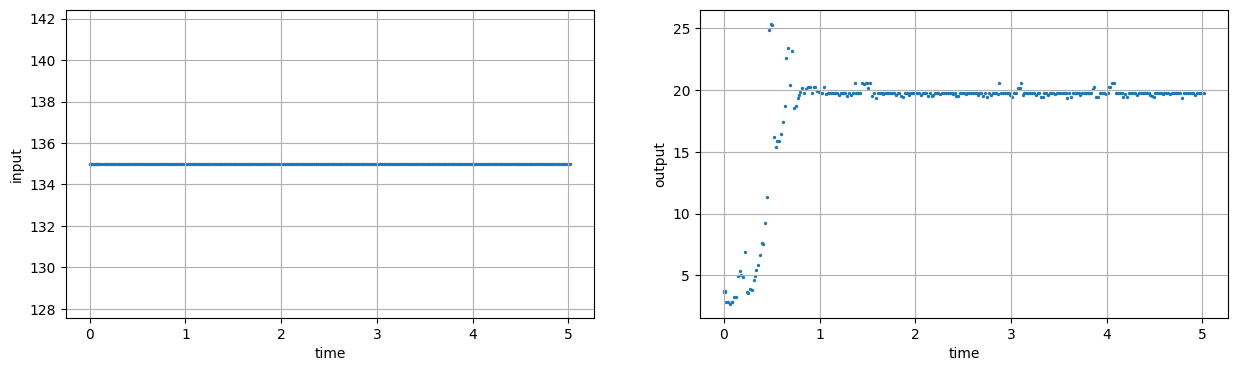

In [59]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

In [60]:
df = df.loc[(df.time < 0.7) & (df.output < 20)]

# PADRONIZANDO OS DADOS

In [61]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.01
df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 65


,time,input,output
0,0.00,135,3.67
1,0.01,135,3.67
2,0.02,135,2.81
3,0.03,135,2.81
4,0.04,135,2.81


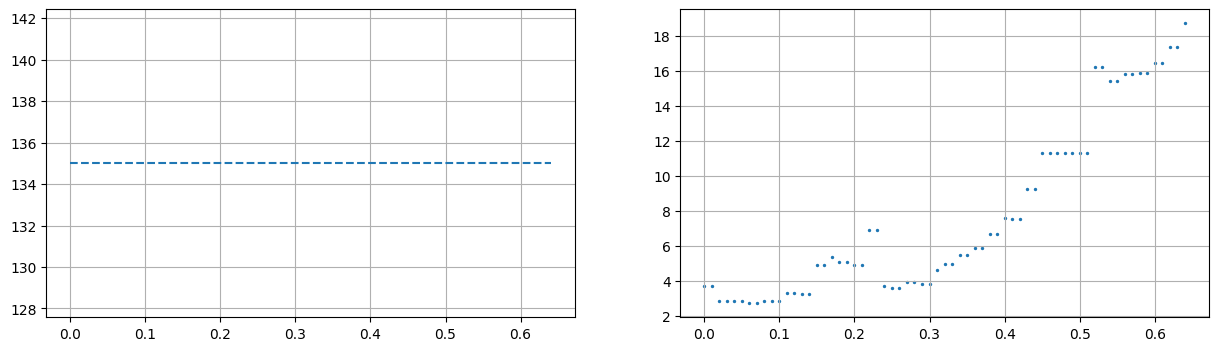

In [62]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.output, s=2)
plt.grid()

In [63]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [64]:
tData, uData, yData = df.time.values, df.input.values, df.output.values

In [ ]:
def g(u, a, b, c):
    s = ctl.TransferFunction.s
    G = a/(s**2 + b*s + c)
    return ctl.forced_response(G, T=tData, U=u)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [66]:
coefs = getFunction(uData, yData)  
coefs

[135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135]
[135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135]
[135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135]
[135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135 135 135 135 135 135 135 135 13

[87039.51089450216, 868875.1994532547, -1875838.8305613948]

In [67]:
s = ctl.TransferFunction.s
a, b, c = coefs

G = a/(s**2 + b*s + c)
G

TransferFunction(array([87039.5108945]), array([ 1.00000000e+00,  8.68875199e+05, -1.87583883e+06]))

### CONFERINDO COM A DATABASE

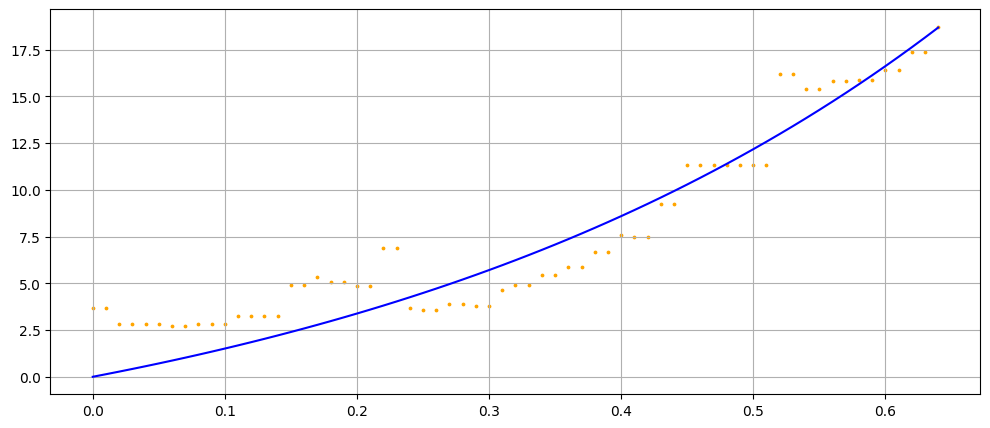

In [68]:
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(time, yData, color='orange', s=3)
plt.grid()

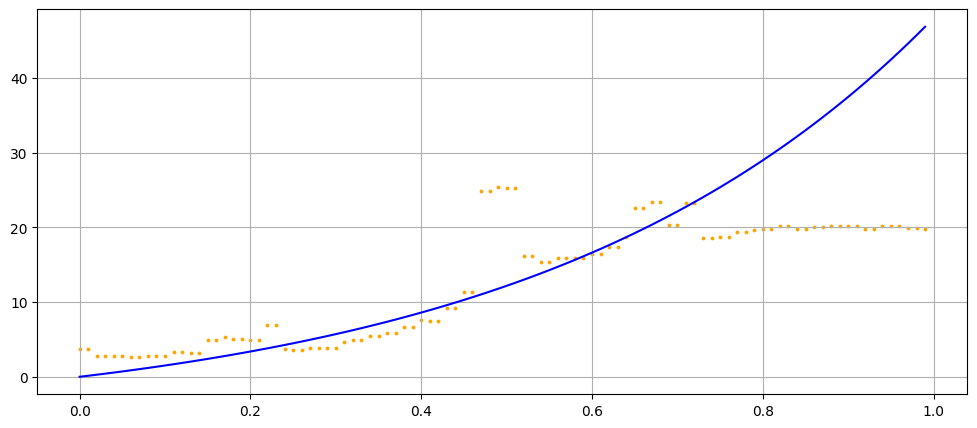

In [69]:
df = pd.read_csv('DataBase.csv')
df = normalizeTable(df, 'time', T)
df = df.loc[df.time < 1]

time, response = ctl.forced_response(G, T=df.time, U=df.input)
plt.figure(figsize=(12, 5))
plt.plot(time, response, color='blue')
plt.scatter(df.time, df.output, color='orange', s=3)
plt.grid()

In [70]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(roundSympyFunction(sympyFunction(G)))

87039.5109/(1.0*s**2 + 868875.1995*s - 1875838.8306)
